In [26]:
import pandas as pd
import matplotlib.pyplot as plt

import psycopg2
import csv

from dotenv import load_dotenv
load_dotenv()

import os

In [27]:
DATABASE_URL_4CHAN = os.environ.get("DATABASE_URL_4CHAN")
DATABASE_URL_REDDIT = os.environ.get("DATABASE_URL_REDDIT")

In [28]:
def fetch_data_from_db(database_url, query):
    try:
        # Create the connection string
        conn = psycopg2.connect(dsn=database_url)
        # Query data from the table
        # query = """
        # SELECT subreddit, count(*) from posts group by subreddit;
        # """
        df = pd.read_sql_query(query, conn)
        conn.close()
        return df
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

In [29]:
query_4chan = """
        SELECT 
            to_timestamp((data->>'time')::BIGINT) :: DATE AS chan_post_date,
            COUNT(*) AS chan_post_count
        FROM 
            posts
        GROUP BY 
            chan_post_date
        ORDER BY 
            chan_post_date;
"""

query_reddit = """
        SELECT 
            DATE(created_at) AS reddit_post_date,
            COUNT(*) AS reddit_post_count
        FROM 
            posts
        GROUP BY 
            reddit_post_date
        ORDER BY 
            reddit_post_date;
"""

query_reddit_comments = """
        SELECT 
            DATE(created_at) AS reddit_comments_date,
            COUNT(*) AS reddit_comments_count
        FROM 
            comments p
        GROUP BY 
            reddit_comments_date
        ORDER BY 
            reddit_comments_date;

"""

In [30]:
df_4chan = fetch_data_from_db(DATABASE_URL_4CHAN, query_4chan)

/tmp/ipykernel_1462189/2940715168.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [31]:
df_4chan.head()

,chan_post_date,chan_post_count
0,2024-09-22,4
1,2024-09-23,28
2,2024-09-24,53
3,2024-09-25,112
4,2024-09-26,208


In [32]:
reddit_df = fetch_data_from_db(DATABASE_URL_REDDIT, query_reddit)

/tmp/ipykernel_1462189/2940715168.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [33]:
reddit_df.head()

,reddit_post_date,reddit_post_count
0,2024-10-19,4
1,2024-10-20,6
2,2024-10-21,49
3,2024-10-22,181
4,2024-10-23,23


In [34]:
reddit_comments_df = fetch_data_from_db(DATABASE_URL_REDDIT, query_reddit_comments)

/tmp/ipykernel_1462189/2940715168.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [35]:
reddit_comments_df.head()

,reddit_comments_date,reddit_comments_count
0,2024-10-21,123
1,2024-10-22,1602
2,2024-10-23,264
3,2024-10-24,2012
4,2024-10-25,9486


## Plot combining all the data collected over every day

In [36]:
# Rename columns for uniformity
df_4chan = df_4chan.rename(columns={df_4chan.columns[0]: "date", df_4chan.columns[1]: "count"})
df_reddit = reddit_df.rename(columns={reddit_df.columns[0]: "date", reddit_df.columns[1]: "count"})
df_reddit_comments = reddit_comments_df.rename(columns={reddit_comments_df.columns[0]: "date", reddit_comments_df.columns[1]: "count"})

In [37]:
df_4chan["source"] = "4chan posts"
df_reddit["source"] = "Reddit posts"
df_reddit_comments["source"] = "Reddit comments"

In [38]:
# Concatenate the dataframes
combined_df = pd.concat([df_4chan, df_reddit, df_reddit_comments])

# Ensure 'date' is in datetime format for proper plotting
combined_df["date"] = pd.to_datetime(combined_df["date"])


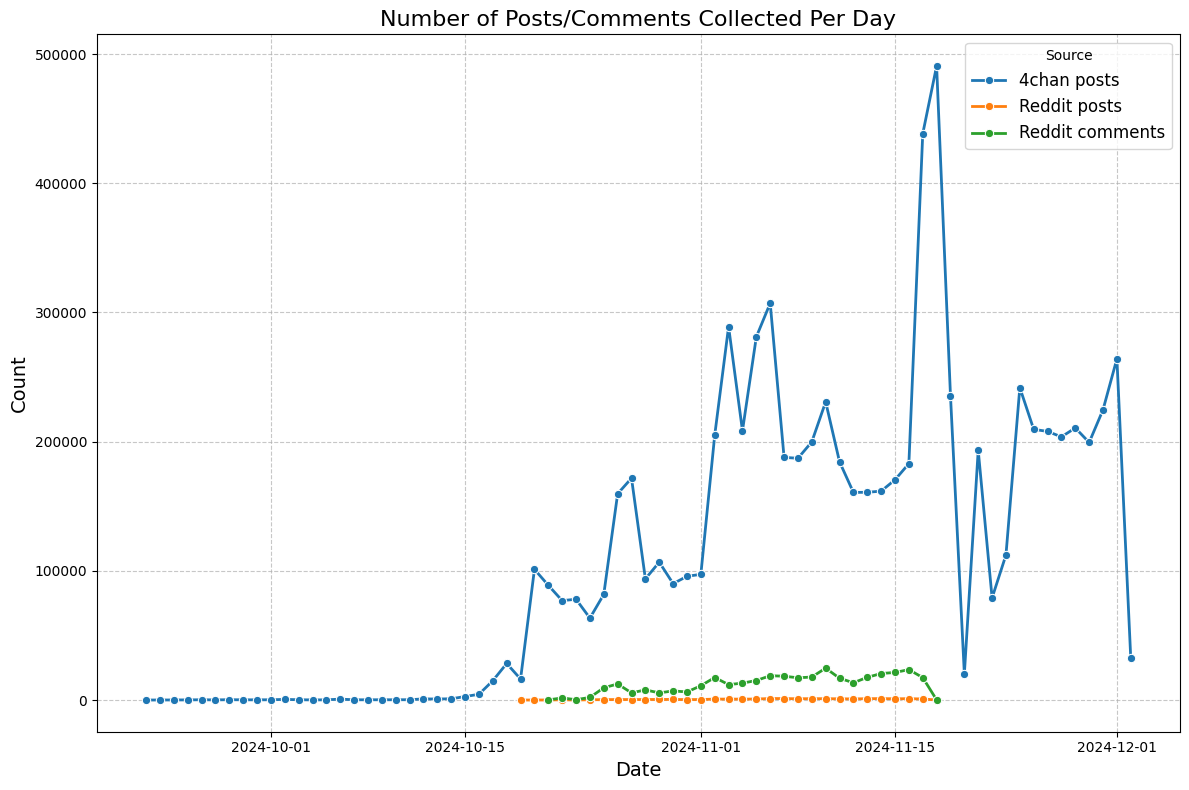

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the combined data
plt.figure(figsize=(12, 8))
sns.lineplot(data=combined_df, x="date", y="count", hue="source", marker="o", linewidth=2)

# Customize the plot
plt.title("Number of Posts/Comments Collected Per Day", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(title="Source", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


## Toxicity comparision between platforms

In [40]:
query_toxic_class_dist_4chan = """
Select 
    toxic_class, count(*) as count 
from 
    posts 
where 
    toxic_class = 'flag' or toxic_class='normal'
group by 
    toxic_class; 
"""

query_toxic_class_dist_reddit_before_nov17 = """
Select 
    toxic_class, count(*) as count 
from 
    comments 
where 
    toxic_class = 'flag' or toxic_class='normal'
group by 
    toxic_class; 
"""

query_toxic_class_dist_reddit_after_nov17 = """
Select 
    toxic_class, count(*) as count 
from 
    comments_from_nov17th
where 
    toxic_class = 'flag' or toxic_class='normal'
group by 
    toxic_class; 
"""

In [41]:
toxic_class_dist_4chan_df = fetch_data_from_db(DATABASE_URL_4CHAN, query_toxic_class_dist_4chan)


/tmp/ipykernel_1462189/2940715168.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [42]:
toxic_class_dist_4chan_df.head()

,toxic_class,count
0,flag,79101
1,normal,3483816


In [43]:
toxic_class_dist_reddit_before_nov17_df = fetch_data_from_db(DATABASE_URL_REDDIT, query_toxic_class_dist_reddit_before_nov17)
toxic_class_dist_reddit_after_nov17_df = fetch_data_from_db(DATABASE_URL_REDDIT, query_toxic_class_dist_reddit_after_nov17)

/tmp/ipykernel_1462189/2940715168.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [44]:
toxic_class_dist_redditdf = pd.concat([toxic_class_dist_reddit_before_nov17_df, toxic_class_dist_reddit_after_nov17_df])
toxic_class_dist_redditdf = toxic_class_dist_redditdf.groupby('toxic_class', as_index=False)['count'].sum()

In [45]:
toxic_class_dist_redditdf.head()

,toxic_class,count
0,flag,6807
1,normal,541719


In [46]:
# Add a platform column to distinguish data sources
toxic_class_dist_4chan_df["platform"] = "4chan"
toxic_class_dist_redditdf["platform"] = "Reddit"

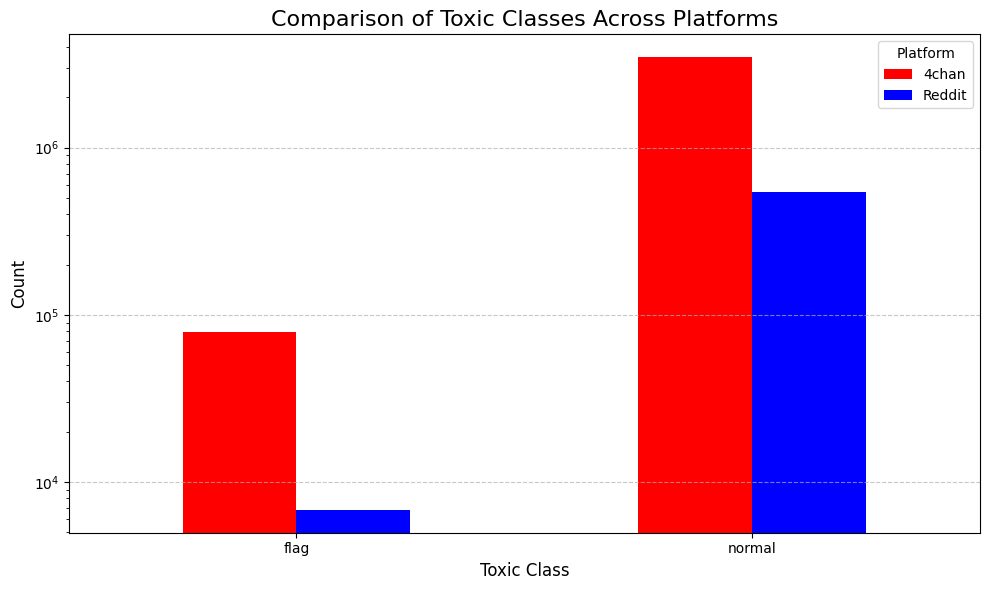

In [47]:
# Combine the dataframes
combined_df = pd.concat([toxic_class_dist_4chan_df, toxic_class_dist_redditdf])

# Pivot data for grouped bar chart
pivoted_df = combined_df.pivot(index="toxic_class", columns="platform", values="count")

# Plot
ax = pivoted_df.plot(kind="bar", figsize=(10, 6), rot=0, color=["red", "blue"])

ax.set_yscale("log")

# Add labels and title
plt.title("Comparison of Toxic Classes Across Platforms", fontsize=16)
plt.xlabel("Toxic Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Platform", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()